<a href="https://colab.research.google.com/github/maulana-tech/TrashClassification-dataset/blob/main/Trasg_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
folder_path = '/content/drive/My Drive/dataset-resized'
os.chdir(folder_path) # Changes the current working directory to your folder

In [4]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/dataset-resized'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/dataset-resized/.DS_Store
/content/drive/My Drive/dataset-resized/model.keras
/content/drive/My Drive/dataset-resized/modeltraining.log
/content/drive/My Drive/dataset-resized/paper/paper240.jpg
/content/drive/My Drive/dataset-resized/paper/paper106.jpg
/content/drive/My Drive/dataset-resized/paper/paper26.jpg
/content/drive/My Drive/dataset-resized/paper/paper175.jpg
/content/drive/My Drive/dataset-resized/paper/paper189.jpg
/content/drive/My Drive/dataset-resized/paper/paper10.jpg
/content/drive/My Drive/dataset-resized/paper/paper220.jpg
/content/drive/My Drive/dataset-resized/paper/paper126.jpg
/content/drive/My Drive/dataset-resized/paper/paper137.jpg
/content/drive/My Drive/dataset-resized/paper/paper25.jpg
/content/drive/My Drive/dataset-resized/paper/paper12.jpg
/content/drive/My Drive/dataset-resized/paper/paper14.jpg
/content/drive/My Drive/dataset-resized/paper/paper143.jpg
/content/drive/My Drive/dataset-resized/paper/paper202.jpg
/content/drive/My D

In [5]:
import tensorflow as tf
import keras.layers as tkl
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import os

In [6]:
data_dir = '/content/drive/My Drive/dataset-resized'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [9]:
val_batches = tf.data.experimental.cardinality(valid_ds)

In [11]:
val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 5)
valid_ds = valid_ds.skip(val_batches // 5)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 13
Number of test batches: 3


In [13]:
AUTOTUNE =  tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [17]:
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# Compile the model with a loss function and an optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [16]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
initial_epochs = 50

In [18]:
callbacks_list = [ModelCheckpoint(filepath='model.keras', monitor='val_accuracy',
                                   verbose=1, save_best_only=True, save_weights_only=False, mode='max')]
csv_logger = CSVLogger('modeltraining.log', separator=',', append=False)

# Train the model on the training set
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=(valid_ds),
                    callbacks=(callbacks_list+[csv_logger]))

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4600 - loss: 13.9377
Epoch 1: val_accuracy improved from -inf to 0.74083, saving model to model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.4616 - loss: 13.9155 - val_accuracy: 0.7408 - val_loss: 9.7235
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7183 - loss: 8.7936
Epoch 2: val_accuracy improved from 0.74083 to 0.75795, saving model to model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 250ms/step - accuracy: 0.7183 - loss: 8.7811 - val_accuracy: 0.7579 - val_loss: 6.3026
Epoch 3/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7636 - loss: 5.7438
Epoch 3: val_accuracy improved from 0.75795 to 0.79218, saving model to model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.7639 - loss: 5.7270 - val_accuracy: 0.7922 - val_loss: 4.0983
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7922 - loss: 3.8099
Epoch 4: val_accuracy improved from 0.79218 to 0.80929, 

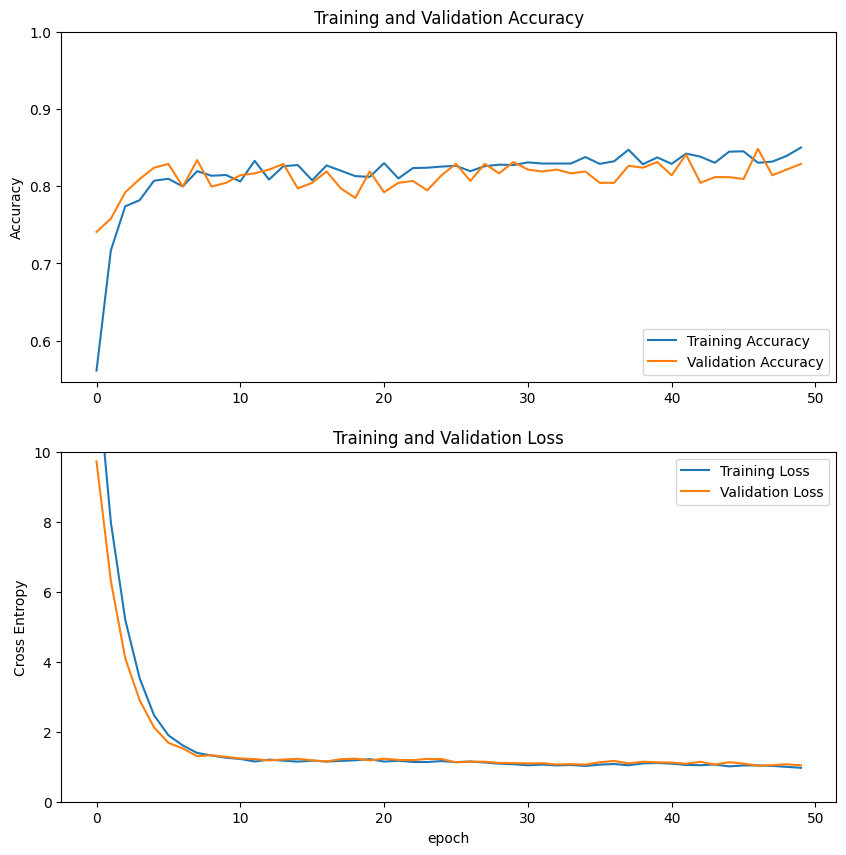

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()),1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [21]:
for layer in base_model.layers:
  layer.trainable = True

In [22]:
base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,079,622 (80.41 MB)

 Trainable params: 21,078,598 (80.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
total_epochs=100

In [1]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         # initial_epochs=history.epoch[-1], Remove initial_epochs argument
                         validation_data=(valid_ds),
                         callbacks=(callbacks_list+[csv_logger]))

NameError: name 'model' is not defined

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_ds)
print('Validation loss: {}, Validation accuracy: {}'.format(val_loss, val_acc))

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

# Adjust the space between the plots
plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

# Adjust the space between the plots
plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

# Load the image
img_path = '/content/drive/My Drive/dataset-resized/glass-test/glass100.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape that the model expects
img_array_expanded = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing function you used during training
img_array_preprocessed = preprocess_input(img_array_expanded)

# Make a prediction
predictions = model.predict(img_array_preprocessed)

# Get the predicted class
predicted_class = class_names[np.argmax(predictions[0])]

# Display the image along with the predicted class
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

In [ ]:
model.save('waste_classification_model13.keras')